Basic imports

In [75]:
import numpy as np
import os
from pandas import DataFrame
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Basic functions for data preprocessing

In [76]:
def drop_line_if_it_contains(data_csv: DataFrame, column: str, value):
    for i in range(len(data_csv[column])):
        if data_csv[column].at[i] == value:
            data_csv.drop([i], axis=0, inplace=True)

    return data_csv

# replacing 0 to NaN in the dataframe
def null_to_NaN(X, except_list):
    cols_with_missing_val = detect_vals(X, 0, except_list).index[0]
    X = replace_val_in_cols(X, [cols_with_missing_val], 0, np.nan)
    return X

# Counting an amount of null values in dataset by column
def detect_vals(obj_to_describe, val, exclude_col=[]):
    # missing values by columns
    obj_to_describe = obj_to_describe.drop(exclude_col, axis=1)
    missing_val_count_by_column = (obj_to_describe.isin([val]).sum())
    return (missing_val_count_by_column)

def read_csv(name):
    return pd.read_csv('../DataSource/' + name, encoding='utf-8')

# Replaces each val in appropriate cols
def replace_val_in_cols(data_csv: DataFrame, column_list, old_value: str, new_value: str):
    for col in column_list:
        data_csv[col] = data_csv[col].replace(old_value, new_value)
    return data_csv

def replace_val_in_cols_except(data_csv: DataFrame, column: str, except_values: [], new_value: str):
    for i in range(len(data_csv[column])):
        if any(x == data_csv[column].at[i] for x in except_values):
            continue
        data_csv[column].at[i] = new_value

    return data_csv

# replacing inf with nan
def replace_inf_with_nan_and_impute(X:DataFrame):
    df = apply_encoder(X)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = simple_imputing_data(df, df)
    return df[0]

Functions for imputing and encoding non numerical values

In [77]:
# Replacing missing values (imputing) according to certain strategy
def simple_imputing_data(X_train, X_valid, strategy:str = 'mean'):
    simple_imputer = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imputed_X_train = pd.DataFrame(simple_imputer.fit_transform(X_train))
    imputed_X_valid = pd.DataFrame(simple_imputer.transform(X_valid))
    # Imputation removed column names; put them back
    imputed_X_train.columns = X_train.columns
    imputed_X_valid.columns = X_valid.columns

    return imputed_X_train, imputed_X_valid

# Encoding labels
def apply_encoder(X: DataFrame):
    s = (X.dtypes == 'object')
    object_cols = list(s[s].index)

    for col in object_cols:
        X[col] = LabelEncoder().fit_transform(X[col])

    return X

Enumerating initial files(DataSource folder) and saving it as single file inlined_ecgs.csv

In [78]:
def prepare_ecg(ECGS_filename):
    source_path = '../DataSource/'
    directory = source_path + 'metrics/'
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            if 'df' not in locals():
                df = read_csv(f)
                df_inlined = inline_single_ecg(df)
            else:
                current_line = read_csv(f)
                df = pd.concat([df, current_line])
                df_inlined = pd.concat([df_inlined, inline_single_ecg(current_line)])

    df.to_csv('../DataSource/' + ECGS_filename)
    df_inlined.to_csv('../DataSource/' + 'inlined_'+ECGS_filename)
    return df_inlined

def inline_single_ecg(df: DataFrame):
    patient_id = df.iloc[0, 0]
    coloumns_to_drop = ['patient_id', 'ecg_id', 'lead']
    for col in coloumns_to_drop:
        df.drop(col, axis=1, inplace=True)
    df.index = df.index + 1
    df_out = df.stack()
    df_out.index = df_out.index.map('{0[1]}_{0[0]}'.format)
    df_inlined = df_out.to_frame().T
    df_inlined['patient_id'] = patient_id
    return df_inlined

Casting to binary task replacing:
    MI as false(0);
    NORM as true(1);
    other values are dropped out from dataframe

In [79]:
from random import uniform
def prepare_dataset_core(name_csv: str):
    df = read_csv('../DataSource/' + name_csv)
    col = 'diagnostic_superclass'
    replace_val_in_cols(df, [col], "['MI']", 'True')
    replace_val_in_cols(df, [col], "['NORM']", 'False')

    replace_val_in_cols_except(df, col, ['True', 'False'], col)
    drop_line_if_it_contains(df, col, col)

    return apply_encoder(df)

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
def estimate(X_train, X_valid, y_train, y_valid, random_state=round(uniform(0, 300))):
    names = [
        "Nearest Neighbors",
        "RBF SVM",
        "Decision Tree",
        "Random Forest",
        "Neural Net",
    ]

    classifiers = [
        KNeighborsClassifier(3),
        SVC(gamma=2, C=1),
        DecisionTreeClassifier(random_state=random_state, max_features='log2'),
        RandomForestClassifier(random_state=random_state, min_samples_split=20,
                               max_features='log2', criterion='entropy'),
        MLPClassifier(alpha=1, max_iter=1000)
    ]

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_valid)
        predictions = [round(value) for value in predictions]
        accuracy = accuracy_score(y_valid, predictions)
        print(name +" :Accuracy: %.3f%%" % (accuracy * 100.0))
        print(name + " :Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))

Building Random Forest Model and measuring it with confusion matrix, accuracy(jaccard_score) and MAE(Mean absolute error regression loss)

In [80]:
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
def build_confusion_matrix(predictions, y_test):
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

from random import uniform
from sklearn.ensemble import RandomForestClassifier
def rfc(X_train, X_valid, y_train, y_valid, random_state=round(uniform(0, 300))):
    reg_model = RandomForestClassifier(n_estimators=10000, n_jobs=-1)
    reg_model = reg_model.fit(X_train, y_train)
    predicted = reg_model.predict(X_valid)
    predictions = [round(value) for value in predicted]
    accuracy = accuracy_score(y_valid, predictions)
    build_confusion_matrix(predicted, y_valid)
    print("Accuracy: %.3f%%" % (accuracy * 100.0))
    print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))

# Splitting to test and train data (82/1)
def prepare_test_data(X_full: DataFrame, beside_list=[]):
    target_column = 'diagnostic_superclass'
    randomState = round(uniform(0, 300))
    y = X_full[target_column]
    X = null_to_NaN(X_full.drop([target_column], axis=1), beside_list)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.82, test_size=0.18, random_state=randomState)

    return (X_train, X_valid, y_train, y_valid, randomState)


import seaborn as sns
def correlation_heatmap(df):
    _, ax = plt.subplots(figsize=(50, 50))
    colormap = sns.diverging_palette(220, 10, as_cmap=True)

    _ = sns.heatmap(
        df.corr("Spearman"),
        cmap=colormap,
        square=True,
        cbar_kws={'shrink': .9},
        ax=ax,
        annot=True,
        linewidths=0.1, vmax=1.0, linecolor='white',
        annot_kws={'fontsize': 8}
    )
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.title('Spearman Correlation of Features', y=1.05, size=15)

Main function. Uncomment line with "prepare_ecg" function only if there is no
joined_data.csv in the DataSource folder(enumerating files might take up to 5 min)

In [81]:
def main_all_sensors():
    patients_info_filename = 'patientsInfo.csv'
    ECGS_filename = '../DataSource/inlined_ecgs.csv'
    path = '../DataSource/'

    # print('converting initial data to single inlined data')
    # # converts initial data to single inlined data/(5min)
    # # run only once if inlined_ecgs.csv was not generated
    # prepare_ecg(ECGS_filename)

    # Joining ECGS_data and patients info
    ECGS_data = read_csv(ECGS_filename)

    # Selecting lines needed
    selected_columns = ['patient_id']
    selected_columns_substrings = ['ibi_', 'sdnn_', 'rmssd_']

    for x in range(1, 13):
        for substring in selected_columns_substrings:
            selected_columns.append(substring + str(x))
    ECGS_data = ECGS_data[selected_columns]

    print('Preparing generated DF(values replacing, imputing)')
    dataframe = prepare_dataset_core(patients_info_filename)

    dataframe = dataframe.drop(columns=['infarction_stadium1', 'infarction_stadium2'])
    X = dataframe.set_index('patient_id').join(ECGS_data.set_index('patient_id'))

    X.to_csv(path + "joined_data_simplified.csv")
    X = replace_inf_with_nan_and_impute(X)

    X_train, X_valid, y_train, y_valid, randomState = prepare_test_data(X)

    print('Models fit comparison')
    estimate(X_train, X_valid, y_train, y_valid, randomState)

    # Execution for optimized random forest model
    print('Building ML model')
    rfc(X_train, X_valid, y_train, y_valid, randomState)

Executing pipeline
Train/test ratio: 82/18

Preparing generated DF(values replacing, imputing)
Models fit comparison
Nearest Neighbors :Accuracy: 72.329%
Nearest Neighbors :Mean Absolute Error: 0.2767062314540059
RBF SVM :Accuracy: 74.221%
RBF SVM :Mean Absolute Error: 0.2577893175074184
Decision Tree :Accuracy: 77.263%
Decision Tree :Mean Absolute Error: 0.2273738872403561
Random Forest :Accuracy: 82.826%
Random Forest :Mean Absolute Error: 0.1717359050445104
Neural Net :Accuracy: 73.961%
Neural Net :Mean Absolute Error: 0.2603857566765579
Building ML model


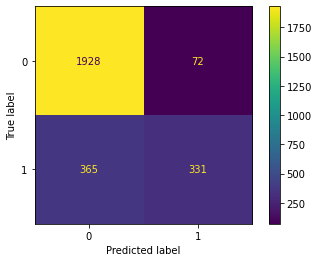

Accuracy: 83.791%
Mean Absolute Error: 0.1620919881305638


In [82]:
main_all_sensors()

Building ML model for 1 sensor


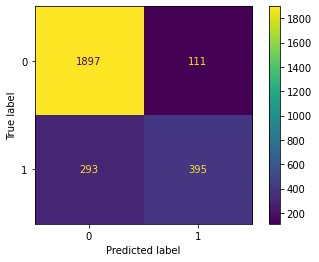

Accuracy: 85.015%
Mean Absolute Error: 0.14985163204747776
Building ML model for 2 sensor


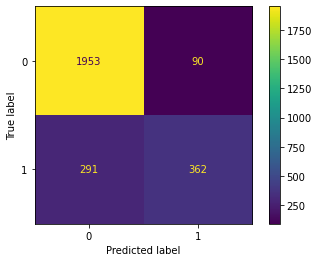

Accuracy: 85.868%
Mean Absolute Error: 0.14132047477744808
Building ML model for 3 sensor


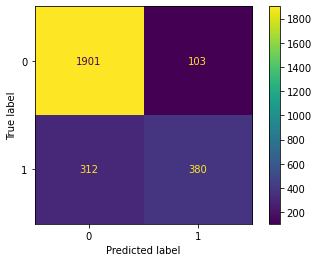

Accuracy: 84.607%
Mean Absolute Error: 0.15393175074183976
Building ML model for 4 sensor


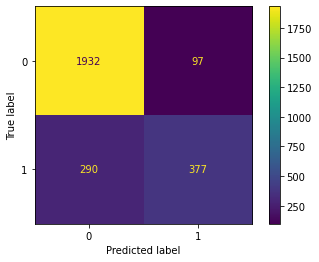

Accuracy: 85.645%
Mean Absolute Error: 0.1435459940652819
Building ML model for 5 sensor


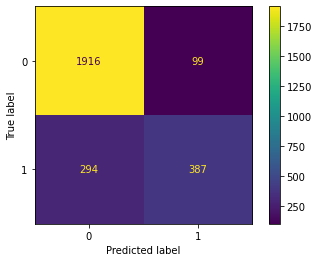

Accuracy: 85.423%
Mean Absolute Error: 0.14577151335311572
Building ML model for 6 sensor


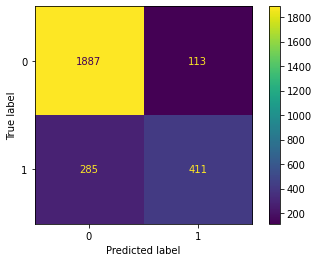

Accuracy: 85.237%
Mean Absolute Error: 0.1476261127596439
Building ML model for 7 sensor


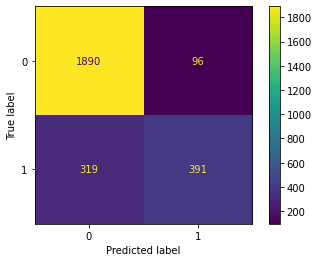

Accuracy: 84.607%
Mean Absolute Error: 0.15393175074183976
Building ML model for 8 sensor


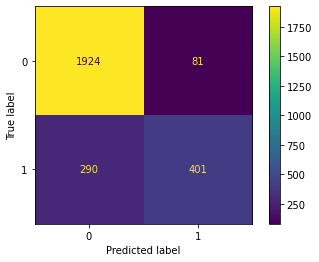

Accuracy: 86.239%
Mean Absolute Error: 0.13761127596439168
Building ML model for 9 sensor


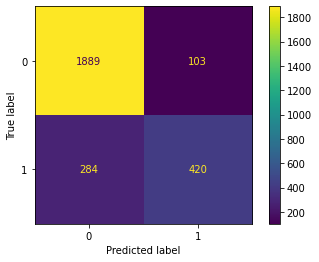

Accuracy: 85.645%
Mean Absolute Error: 0.1435459940652819
Building ML model for 10 sensor


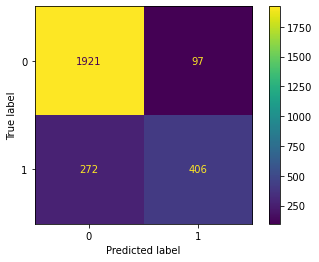

Accuracy: 86.313%
Mean Absolute Error: 0.1368694362017804
Building ML model for 11 sensor


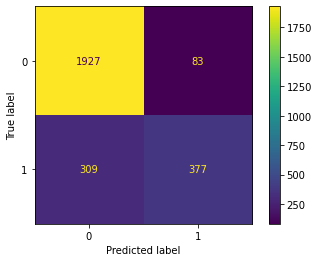

Accuracy: 85.460%
Mean Absolute Error: 0.14540059347181009
Building ML model for 12 sensor


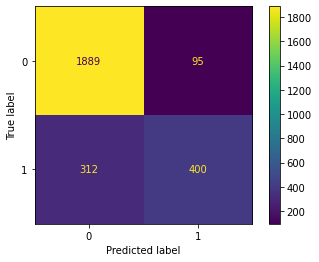

Accuracy: 84.904%
Mean Absolute Error: 0.15096439169139467


KeyboardInterrupt: 

In [116]:
def main_all_sensors():
    patients_info_filename = 'patientsInfo.csv'
    ECGS_filename = '../DataSource/inlined_ecgs.csv'
    path = '../DataSource/'

    # print('converting initial data to single inlined data')
    # # converts initial data to single inlined data/(5min)
    # # run only once if inlined_ecgs.csv was not generated
    # prepare_ecg(ECGS_filename)

    # Joining ECGS_data and patients info

    for x in range(1, 13):
        ECGS_data = read_csv(ECGS_filename)

        # Selecting lines needed
        selected_columns = ['patient_id']
        selected_columns_substrings = ['ibi_', 'sdnn_', 'rmssd_']


        for substring in selected_columns_substrings:
            selected_columns.append(substring + str(x))
        ECGS_data = ECGS_data[selected_columns]

        dataframe = prepare_dataset_core(patients_info_filename)

        dataframe = dataframe.drop(columns=['infarction_stadium1', 'infarction_stadium2'])
        X = dataframe.set_index('patient_id').join(ECGS_data.set_index('patient_id'))

        X.to_csv(path + "joined_data_simplified.csv")
        X = replace_inf_with_nan_and_impute(X)

        X_train, X_valid, y_train, y_valid, randomState = prepare_test_data(X)

        # Execution for optimized random forest model
        print(f'Building ML model for {x} sensor')
        rfc(X_train, X_valid, y_train, y_valid, randomState)

main_all_sensors()